### Bayesian Data Analysis, 3rd ed
## Chapter 3, demos 1-4

Authors:
- Aki Vehtari <aki.vehtari@aalto.fi>
- Tuomas Sivula <tuomas.sivula@aalto.fi>

Examples and illustrations for a normal model with unknown mean and variance
(BDA3 section 3.2 on p. 64).

In [1]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import sinvchi2
import plot_tools

In [3]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [4]:
# data
y = np.array([93, 112, 122, 135, 122, 150, 118, 90, 124, 114])
# sufficient statistics
n = len(y)
s2 = np.var(y, ddof=1)  # here ddof=1 is used to get the sample estimate
my = np.mean(y)

In [5]:
# set random number generator with seed
rng = np.random.RandomState(seed=0)

In [6]:
# factorize the joint posterior p(mu,sigma2|y) to p(sigma2|y)p(mu|sigma2,y)
# sample from the joint posterior using this factorization

# sample from p(sigma2|y)
sigma2 = sinvchi2.rvs(n-1, s2, size=1000, random_state=rng)
# sample from p(mu|sigma2,y) 
mu = my + np.sqrt(sigma2/n)*rng.randn(*sigma2.shape)
# display sigma instead of sigma2
sigma = np.sqrt(sigma2)
# sample from the predictive distribution p(ynew|y)
# for each sample of (mu, sigma)
ynew = rng.randn(*mu.shape)*sigma + mu

In [7]:
# for mu compute the density in these points
tl1 = [90, 150]
t1 = np.linspace(tl1[0], tl1[1], 1000)
# for sigma compute the density in these points
tl2 = [10, 60]
t2 = np.linspace(tl2[0], tl2[1], 1000)
# for ynew compute the density in these points
tlynew = [50, 185]
xynew = np.linspace(tlynew[0], tlynew[1], 1000)

# evaluate the joint density in a grid
# note that the following is not normalized, but for plotting
# contours it does not matter
Z = stats.norm.pdf(t1, my, t2[:,np.newaxis]/np.sqrt(n))
Z *= (sinvchi2.pdf(t2**2, n-1, s2)*2*t2)[:,np.newaxis]

# compute the exact marginal density for mu
# multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# z=(x-mean(y))/sqrt(s2/n), see BDA3 p. 21
pm_mu = stats.t.pdf((t1 - my) / np.sqrt(s2/n), n-1) / np.sqrt(s2/n)

# estimate the marginal density for mu using samples and an ad hoc Gaussian
# kernel approximation
pk_mu = stats.gaussian_kde(mu).evaluate(t1)

# compute the exact marginal density for sigma
# multiplication by 2*t2 is due to the transformation of variable
# z=t2^2, see BDA3 p. 21
pm_sigma = sinvchi2.pdf(t2**2, n-1, s2)*2*t2
# N.B. this was already calculated in the joint distribution case

# estimate the marginal density for sigma using samples and an ad hoc Gaussian
# kernel approximation
pk_sigma = stats.gaussian_kde(sigma).evaluate(t2)

# compute the exact predictive density
# multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# see BDA3 p. 21
p_new = stats.t.pdf((xynew-my)/np.sqrt(s2*(1+1/n)), n-1) / np.sqrt(s2*(1+1/n))

Visualise the joint density and marginal densities of the posterior of normal 
distribution with unknown mean and variance.

Joint and marginal posterior distributions


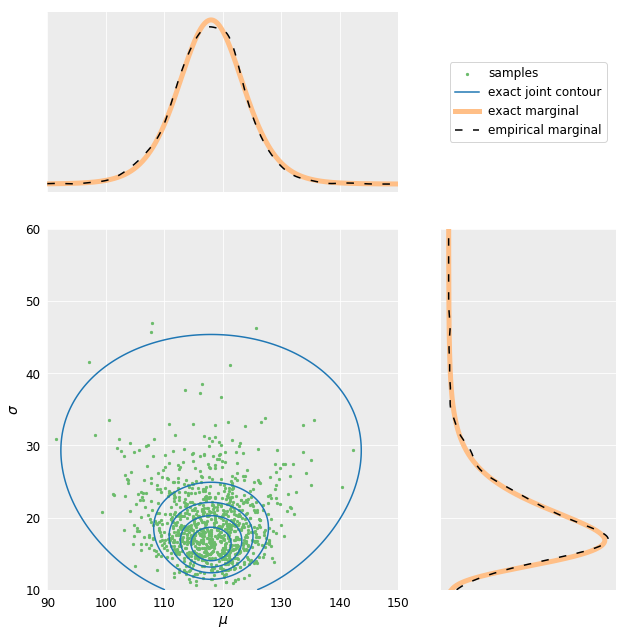

In [8]:
print('Joint and marginal posterior distributions')

# create figure
fig, axes = plt.subplots(
    2, 2,
    figsize=(9, 9),
    gridspec_kw=dict(
        width_ratios=[2, 1],
        height_ratios=[1, 2]
    )
)

# plot the joint distribution
ax = axes[1, 0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize='14')
ax.set_ylabel('$\sigma$', fontsize='14')

# plot the marginal of mu
ax = axes[0, 0]
# exact
ax.plot(
    t1,
    pm_mu,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
ax.plot(
    t1,
    pk_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_xlim(tl1)
ax.set_yticks(())
ax.set_xticklabels(())

# plot the marginal of sigma
ax = axes[1, 1]
# exact
exact_line, = ax.plot(
    pm_sigma,
    t2,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
empirical_line, = ax.plot(
    pk_sigma,
    t2,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_ylim(tl2)
ax.set_xticks(())
ax.set_yticklabels(())

# hide last ax
ax = axes[0, 1]
ax.axis('off')
# make legend there
ax.legend(
    (
        samps,
        plt.Line2D([], [], color='C0'),
        exact_line,
        empirical_line
    ),
    (
        'samples',
        'exact joint contour',
        'exact marginal',
        'empirical marginal'
    ),
    loc='center',
)

fig.tight_layout()

Visualise factored sampling and the corresponding marginal and conditional densities.

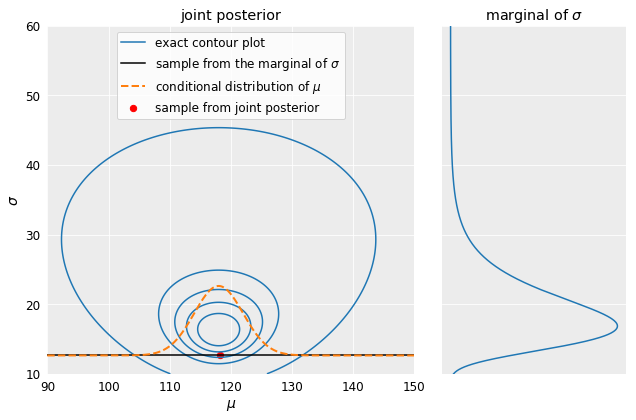

In [9]:
# create figure
fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 6),
    gridspec_kw=dict(width_ratios=[2, 1])
)

# plot the joint distribution
ax = axes[0]
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')

# plot the first sample
line1, = ax.plot(tl1, [sigma[0], sigma[0]], 'k')
line2, = ax.plot(
    t1,
    sigma[0] + stats.norm.pdf(t1, my, np.sqrt(sigma2[0]/n))*100,
    color='C1',
    linestyle='dashed',
    linewidth=2
)
scat = ax.scatter(mu[0], sigma[0], 40, color='r')

# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_title('joint posterior')
ax.legend(
    (plt.Line2D([], [], color='C0'), line1, line2, scat),
    ('exact contour plot',
     'sample from the marginal of $\\sigma$',
     'conditional distribution of $\\mu$',
     'sample from joint posterior'),
    loc='upper center'
)

# plot the marginal of sigma
ax = axes[1]
ax.plot(pm_sigma, t2)
# decorate
ax.set_ylim(tl2)
ax.set_title('marginal of $\sigma$')
ax.set_xticks(());
ax.set_yticklabels(())

fig.tight_layout()

Visualise the marginal distribution of mu as a mixture of normals.

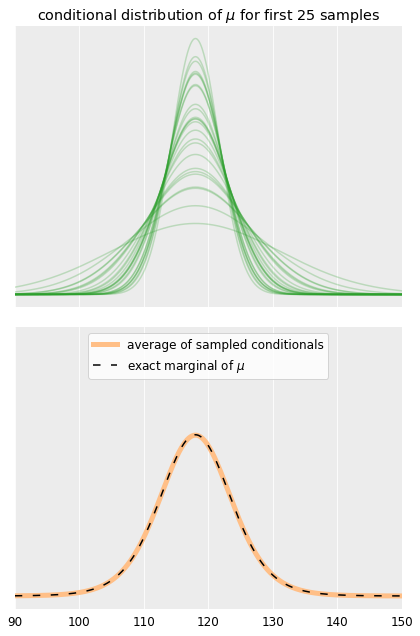

In [10]:
# calculate conditional pdfs for each sample
condpdfs = stats.norm.pdf(t1, my, np.sqrt(sigma2/n)[:,np.newaxis])

# create figure
fig, axes = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

# plot some of them
ax = axes[0]
ax.plot(t1, condpdfs[:25].T, 'C2', alpha=0.25)
ax.set_xlim(tl1)
ylims_from_0 = ax.set_ylim()  # set same y_lims to the next plot
ax.set_title('conditional distribution of $\\mu$ for first 25 samples')
ax.set_yticks(())

# plot their mean
ax = axes[1]
ax.plot(
    t1,
    np.mean(condpdfs, axis=0),
    color=plot_tools.lighten('C1'),
    linewidth=5,
    label='average of sampled conditionals'
)
ax.plot(
    t1,
    pm_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5,
    label='exact marginal of $\\mu$'
)
ax.set_yticks(())
ax.set_xlim(tl1)
ax.set_ylim(ylims_from_0)
ax.legend(loc='upper center')

fig.tight_layout()

Visualise sampling from the posterior predictive distribution.

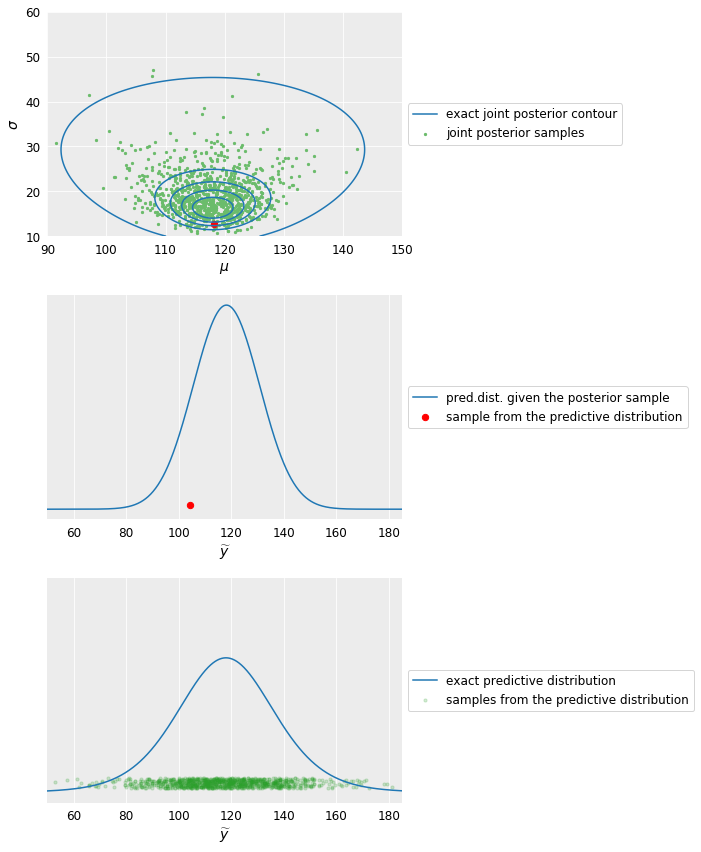

In [11]:
# calculate predictive pdf for the first given mu and sigma sample
ynewdists = stats.norm.pdf(xynew, mu[0], sigma[0])

# create figure
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# plot the joint distribution
ax = axes[0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.legend(
    (plt.Line2D([], [], color='C0'), samps),
    ('exact joint posterior contour', 'joint posterior samples'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
# highlight the first sample
ax.scatter(mu[0], sigma[0], 40, 'r')

# plot first ynew
ax = axes[1]
# plot the distribution and the respective sample
line1, = ax.plot(xynew, ynewdists)
ax1_hs = ax.scatter(ynew[0], 0.02*np.max(ynewdists), 40, 'r')
# decorate
ylims_from_1 = ax.set_ylim()
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(
    (line1, ax1_hs),
    ('pred.dist. given the posterior sample',
    'sample from the predictive distribution'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

# plot all ynews
ax = axes[2]
ax.scatter(
    ynew,
    (0.02 + 0.05*rng.rand(*ynew.shape))*np.max(ynewdists),
    10,
    color='C2',
    alpha=0.2,
    label='samples from the predictive distribution'
)
ax.plot(
    xynew,
    p_new,
    linewidth=1.5,
    label='exact predictive distribution'
)
ax.set_ylim(ylims_from_1)
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()